# Scraping all tables from Numbeo

In [208]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Define the range of years to extract data
start_year = 2012
end_year = 2023

# Create an empty list to store the extracted tables
dfs = []

# Define the URL pattern
url_pattern = "https://www.numbeo.com/quality-of-life/rankings_by_country.jsp?title={}"

# Loop over the years
for year in range(start_year, end_year + 1):
    # Loop over the URL types: full year, mid year, and first two years
    for url_type in ['{}', '{}-mid', '{}-Q1']:
        # Create the URL for the current year and URL type
        url = url_pattern.format(url_type.format(year))

        # Send a GET request to the URL
        response = requests.get(url)

        # Create a BeautifulSoup object with the response text
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find the table with the specified ID
        table = soup.find('table', {'id': 't2'})

        # Extract the column names from the table header
        header_row = table.find('thead').find('tr')
        headers = [header.text.strip() for header in header_row.find_all('th')]
        headers = headers[1:]  # Remove the first column

        # Extract the data rows from the table
        data = []
        for row in table.find_all('tbody'):
            for tr in row.find_all('tr'):
                row_data = [td.text.strip() for td in tr.find_all('td')]
                if len(row_data) > 0:
                    data.append(row_data[1:])  # Remove the first empty column

        # Create a Pandas DataFrame for the data
        df = pd.DataFrame(data, columns=headers)

        # Add a column with the year type
        if url_type == '{}':
            year_type = 'Preliminary'
        else:
            year_type = 'Revised'
        df.insert(0, 'Year Type', year_type)

        # Add a column with the year
        df.insert(1, 'Year', year)

        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
result_df = pd.concat(dfs, ignore_index=True)

# Print the resulting DataFrame
print(result_df)

        Year Type  Year               Country Quality of Life Index Purchasing Power Index Safety Index Health Care Index Cost of Living Index Property Price to Income Ratio Traffic Commute Time Index Pollution Index Climate Index
0         Revised  2012           Switzerland                 194.1                  127.4         74.2              79.5                148.7                            6.5                       30.9            35.5             -
1         Revised  2012               Germany                 184.4                  114.2         78.8              72.0                 92.8                            4.8                       33.1            45.1             -
2         Revised  2012                Norway                 183.4                   94.2         80.9              79.0                166.6                            7.1                       18.5            19.2             -
3         Revised  2012  United Arab Emirates                 177.1         

In [209]:
# Replace the country 'Hong Kong (China) with 'Hong Kong'
result_df['Country'] = result_df['Country'].str.replace('Hong Kong \(China\)', 'Hong Kong')

# Replace the country 'Hong Kong (China) with 'Hong Kong'
result_df['Country'] = result_df['Country'].str.replace('Taiwan \(China\)', 'Taiwan')

C:\Users\macko\AppData\Local\Temp\ipykernel_28008\2346580928.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  result_df['Country'] = result_df['Country'].str.replace('Hong Kong \(China\)', 'Hong Kong')
C:\Users\macko\AppData\Local\Temp\ipykernel_28008\2346580928.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  result_df['Country'] = result_df['Country'].str.replace('Taiwan \(China\)', 'Taiwan')


# Preprocessing

In [210]:
# if a year is missing for a specific country for 'Revised' use the 'Preliminary' data
filtered_df = result_df.groupby(['Country', 'Year']).last().reset_index()

In [211]:
# Keep only the revised data for all years, except for the last year
end_year_df = result_df[(result_df['Year Type'] == 'Revised') | (result_df['Year'] == end_year)]

In [212]:
# concatenate filtered_df and result_df and remove the duplicates
new_df = pd.concat([end_year_df, filtered_df], ignore_index=True)

In [213]:
# Remove duplicates in new_df
new_df = new_df.drop_duplicates(subset=['Country', 'Year'], keep='last')

In [214]:
# export to csv ignoring the index
# new_df.to_csv('numbeo.csv', index=False)

In [215]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 847 to 1735
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Year Type                       889 non-null    object
 1   Year                            889 non-null    int64 
 2   Country                         889 non-null    object
 3   Quality of Life Index           889 non-null    object
 4   Purchasing Power Index          889 non-null    object
 5   Safety Index                    889 non-null    object
 6   Health Care Index               889 non-null    object
 7   Cost of Living Index            889 non-null    object
 8   Property Price to Income Ratio  889 non-null    object
 9   Traffic Commute Time Index      889 non-null    object
 10  Pollution Index                 889 non-null    object
 11  Climate Index                   889 non-null    object
dtypes: int64(1), object(11)
memory usage: 90.3+ KB


In [216]:
# convert all columns to numeric
new_df = new_df.apply(pd.to_numeric, errors='ignore')
new_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 847 to 1735
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Year Type                       889 non-null    object 
 1   Year                            889 non-null    int64  
 2   Country                         889 non-null    object 
 3   Quality of Life Index           889 non-null    float64
 4   Purchasing Power Index          889 non-null    float64
 5   Safety Index                    889 non-null    float64
 6   Health Care Index               889 non-null    float64
 7   Cost of Living Index            889 non-null    float64
 8   Property Price to Income Ratio  889 non-null    float64
 9   Traffic Commute Time Index      889 non-null    float64
 10  Pollution Index                 889 non-null    float64
 11  Climate Index                   889 non-null    object 
dtypes: float64(8), int64(1), object(3

In [217]:
# Climate index wasn't converted to numeric because it has some missing values marked as '-'
new_df['Climate Index'].value_counts()

-        280
86.0       9
68.4       8
71.2       8
78.1       7
        ... 
63.7       1
72.0       1
89.5       1
89.3       1
-12.9      1
Name: Climate Index, Length: 280, dtype: int64

In [218]:
import numpy as np

# Fill all '-' values with NaN
new_df = new_df.replace('-', np.nan)

new_df['Climate Index'] = new_df['Climate Index'].astype(float)

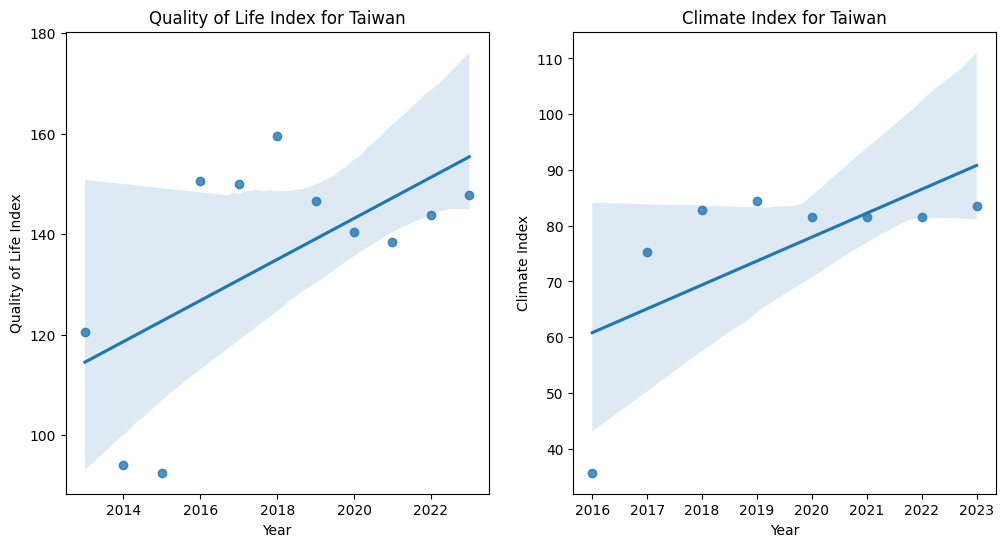

In [219]:
group = new_df[new_df['Country'] == 'Taiwan']
import matplotlib.pyplot as plt
import seaborn as sns

# Plot several regplots on the same figure, one for Quality of life, one for Climate Index
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.regplot(x='Year', y='Quality of Life Index', data=group, ax=axes[0])
sns.regplot(x='Year', y='Climate Index', data=group, ax=axes[1])

# Add titles
axes[0].set_title('Quality of Life Index for Taiwan')
axes[1].set_title('Climate Index for Taiwan')

plt.show()

## Data for climate index starts in 2016. Let's fill the NaNs using LinearRegression approach

In [220]:
new_df.columns

Index(['Year Type', 'Year', 'Country', 'Quality of Life Index', 'Purchasing Power Index', 'Safety Index', 'Health Care Index', 'Cost of Living Index', 'Property Price to Income Ratio', 'Traffic Commute Time Index', 'Pollution Index', 'Climate Index'], dtype='object')

In [221]:
from sklearn.linear_model import LinearRegression

df_encoded = pd.get_dummies(new_df, columns=['Country'])
df_missing = df_encoded[df_encoded['Year'].between(2012, 2015)]
df_available = df_encoded[df_encoded['Year'] >= 2016]

In [222]:
for index_column in ['Climate Index']:
    # Prepare the data for linear regression
    X_train = df_available[['Year'] + df_available.columns[df_available.columns.str.startswith('Country_')].tolist()]
    y_train = df_available[index_column]
    X_test = df_missing[['Year'] + df_missing.columns[df_missing.columns.str.startswith('Country_')].tolist()]

    # Fit the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict the missing values
    y_pred = model.predict(X_test)

    # Fill in the missing values in the original dataframe
    df_missing[index_column] = y_pred

C:\Users\macko\AppData\Local\Temp\ipykernel_28008\2269764921.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing[index_column] = y_pred


In [223]:
# df_missing.head()

In [224]:
# Use the ;'Climate Index' column from df_missing to fill the missing values in df_encoded
df_encoded['Climate Index'] = df_encoded['Climate Index'].fillna(df_missing['Climate Index'])
# df_encoded.head()

In [225]:
df_imputed = df_encoded.sort_values(['Year'])
 
# df_imputed.head()

In [226]:
# Extract the country names from the dummy variable column names
country_names = [col.split('_')[1] for col in df_imputed.columns if col.startswith('Country_')]

# country_names
# Create the "Country" column
df_imputed['Country'] = ''

# Iterate over each row and assign country names based on the dummy variables
for index, row in df_imputed.iterrows():
    for country in country_names:
        if row[f'Country_{country}'] == 1:
            df_imputed.at[index, 'Country'] = country
            break  # Exit the loop once a country is found

# Print the updated DataFrame
# print(df_imputed)

In [227]:
# Drop all the 'Country_' columns
df_imputed = df_imputed.drop(columns=df_imputed.columns[df_imputed.columns.str.startswith('Country_')])
# df_imputed.head()

## Graphing Taiwan again to see if the index value for previous years follow the regression line 

In [228]:
group

,Year Type,Year,Country,Quality of Life Index,Purchasing Power Index,Safety Index,Health Care Index,Cost of Living Index,Property Price to Income Ratio,Traffic Commute Time Index,Pollution Index,Climate Index
1627,Revised,2013,Taiwan,120.6,74.2,83.7,81.2,66.8,9.0,38.3,71.5,NaN
1628,Revised,2014,Taiwan,94.0,65.7,78.6,82.3,59.4,24.1,25.1,64.1,NaN
1629,Preliminary,2015,Taiwan,92.5,69.9,78.1,84.3,57.1,25.0,28.2,67.6,NaN
1630,Revised,2016,Taiwan,150.6,113.2,80.5,84.7,57.4,15.5,33.6,64.3,35.7
1631,Revised,2017,Taiwan,150.0,94.9,81.7,82.8,66.8,13.8,35.8,62.9,75.2
1632,Revised,2018,Taiwan,159.5,102.1,78.6,85.3,59.7,17.5,32.7,63.9,82.9
1633,Revised,2019,Taiwan,146.6,74.2,83.8,86.9,58.8,23.2,32.0,64.2,84.4
1634,Revised,2020,Taiwan,140.5,61.4,84.7,86.4,61.9,24.2,31.5,63.1,81.6
1635,Revised,2021,Taiwan,138.5,51.1,84.5,86.4,64.9,21.8,31.4,63.0,81.6
1636,Revised,2022,Taiwan,143.8,61.8,83.9,86.0,55.9,19.7,31.7,64.9,81.6


In [229]:
# Round the 'Climate Index to 1 decimal place in df_imputed
df_imputed['Climate Index'] = df_imputed['Climate Index'].round(1)

# Save 'Country' as third column using insert()
df_imputed.insert(2, 'Country', df_imputed.pop('Country'))

group_imputed = df_imputed[df_imputed['Country'] == 'Taiwan']

group_imputed

,Year Type,Year,Country,Quality of Life Index,Purchasing Power Index,Safety Index,Health Care Index,Cost of Living Index,Property Price to Income Ratio,Traffic Commute Time Index,Pollution Index,Climate Index
1627,Revised,2013,Taiwan,120.6,74.2,83.7,81.2,66.8,9.0,38.3,71.5,60.7
1628,Revised,2014,Taiwan,94.0,65.7,78.6,82.3,59.4,24.1,25.1,64.1,63.0
1629,Preliminary,2015,Taiwan,92.5,69.9,78.1,84.3,57.1,25.0,28.2,67.6,65.4
1630,Revised,2016,Taiwan,150.6,113.2,80.5,84.7,57.4,15.5,33.6,64.3,35.7
1631,Revised,2017,Taiwan,150.0,94.9,81.7,82.8,66.8,13.8,35.8,62.9,75.2
1632,Revised,2018,Taiwan,159.5,102.1,78.6,85.3,59.7,17.5,32.7,63.9,82.9
1633,Revised,2019,Taiwan,146.6,74.2,83.8,86.9,58.8,23.2,32.0,64.2,84.4
1634,Revised,2020,Taiwan,140.5,61.4,84.7,86.4,61.9,24.2,31.5,63.1,81.6
1635,Revised,2021,Taiwan,138.5,51.1,84.5,86.4,64.9,21.8,31.4,63.0,81.6
1636,Revised,2022,Taiwan,143.8,61.8,83.9,86.0,55.9,19.7,31.7,64.9,81.6


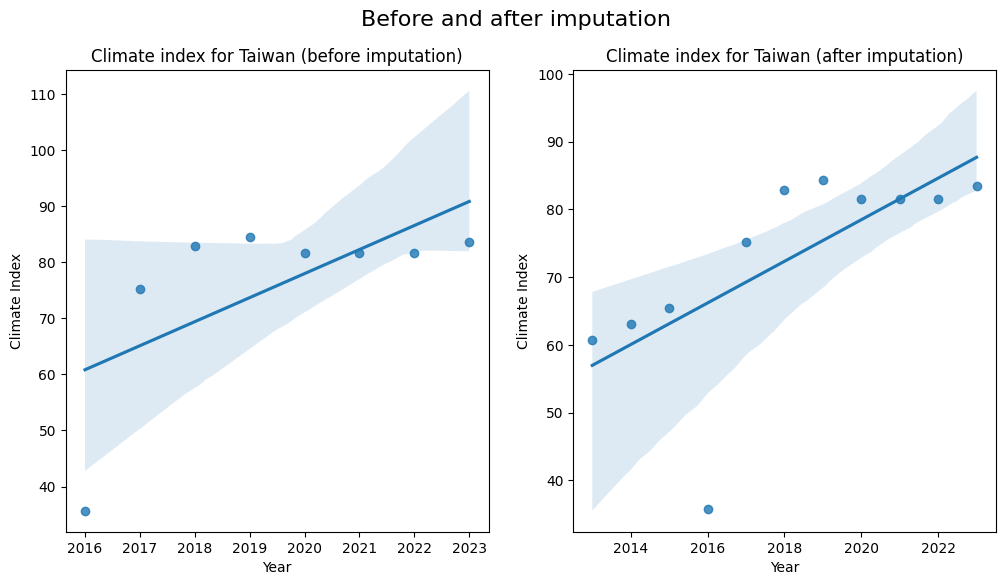

In [236]:
# Plot several regplots on the same figure, one for Quality of life, one for Climate Index
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.regplot(x='Year', y='Climate Index', data=group, ax=axes[0])
sns.regplot(x='Year', y='Climate Index', data=group_imputed, ax=axes[1])
plt.suptitle('Before and after imputation', fontsize=16)

# Add titles
axes[0].set_title('Climate index for Taiwan (before imputation)')
axes[1].set_title('Climate index for Taiwan (after imputation)')

plt.show()